In [1]:
#@title Import Modules 

import os
import glob
import numpy as np
import pandas as pd

#Machine Learning Tools
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Peak Finding
from scipy.stats import norm, multivariate_normal
import scipy.signal as ss

#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

#gdown Installation
!pip install gdown==3.6.0

  Created wheel for gdown: filename=gdown-3.6.0-cp37-none-any.whl size=5237 sha256=5e0c367448f6f875d3f26a2f3152338752cfe7337ce2c25ffaa0dba8091daeb4
  Stored in directory: /root/.cache/pip/wheels/97/90/fa/25654eb65da3e6da7752db71a164e0eb8f7a6fb4335eeb46ab
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


## User Input

In [2]:
#@title Experimental Data 

#Names of Precursors
precursor1 = '$FAPbI_3$' #@param {type:"string"}
precursor2 = '$FAPbBr_33$' #@param {type:"string"}

#Wells that we should ignore
wells_to_ignore = 'B7' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 500 #@param {type:"integer"}
end_wavelength =  850 #@param {type:"integer"}
wavelength_step_size =  5 #@param {type:"integer"}

time_step = 7 #@param {type:"integer"}

#Information about the reads
number_of_reads =   50 #@param {type:"integer"}
luminescence_read_numbers = '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50' #@param {type:"string"}

#Convert the string into a list to use later 

wells_to_ignore = list(wells_to_ignore.split(","))
luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [3]:
#@title Data Information

#Name of files 
data_file_name = '09.06.2020 - FAPbI3 and FAPbBr3 - Chloroform.csv' #@param {type:'string'}
composition_file_name = '0.0 - Compositions.csv' #@param {type:'string'}

#Download the correct data
data_file = '1UBKDYYkV0vISGPVQweWxgu82ruJYO46R' #@param {type:"string"}
composition_file = '1yBVvZhv-4qdR24JMsYADjQ_mi3CaqLh1' #@param {type:"string"}

## Downloading and Formating Data

In [4]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1UBKDYYkV0vISGPVQweWxgu82ruJYO46R
To: /content/09.06.2020 - FAPbI3 and FAPbBr3 - Chloroform.csv
100% 1.27M/1.27M [00:00<00:00, 93.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yBVvZhv-4qdR24JMsYADjQ_mi3CaqLh1
To: /content/0.0 - Compositions.csv
100% 1.05k/1.05k [00:00<00:00, 1.51MB/s]


In [5]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name, header=None)
rawData = rawData.replace('OVRFLW', np.NaN)

composition = pd.read_csv(composition_file_name, index_col = 0)


In [6]:
#@title Parsing the Data into a Dictionary


for i in wells_to_ignore: 
  composition = composition.drop(i, axis = 1)

#First the rows of measurements 
rows = []

for i in range(1, number_of_reads + 1): 
  
  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()

rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes 

#First step, make a list of the names 
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary 
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values 
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column
  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore: 
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers

In [7]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]

#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:
  
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)

luminescence_vec = np.array(luminescence_df)


## Time Zero Plot

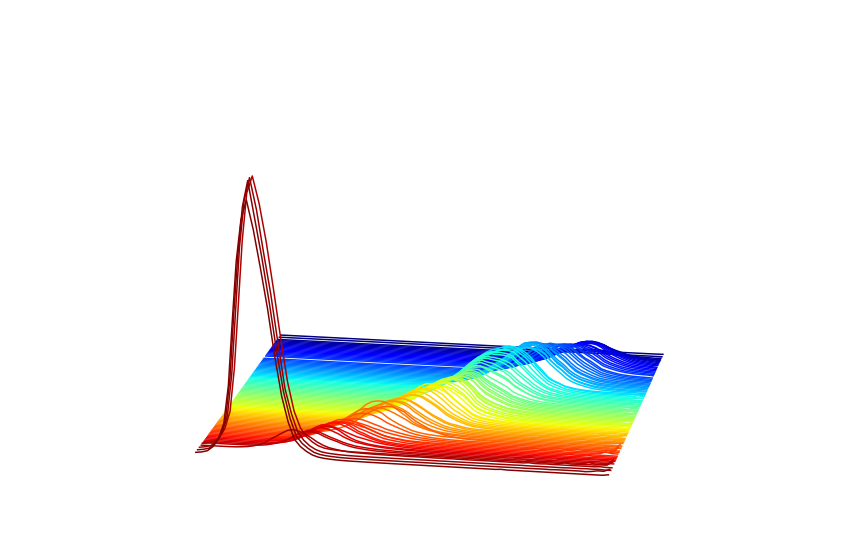

In [8]:
from mpl_toolkits import mplot3d

compositions = np.array(composition.iloc[0]) * 2

nx, ny = np.meshgrid(compositions, luminescence_wavelength)

luminescence = np.array(d['Read 1'].drop(['Wavelength'], axis = 1))

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

colors = cm.jet(np.linspace(0, 1, len(compositions)))

for j in range(len(compositions)):
  comp =  np.full((len(luminescence_wavelength)), compositions[j])
  ax.plot(luminescence_wavelength, comp, luminescence[:, j], c = colors[j])

ax.view_init(25, -80)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_axis_off()


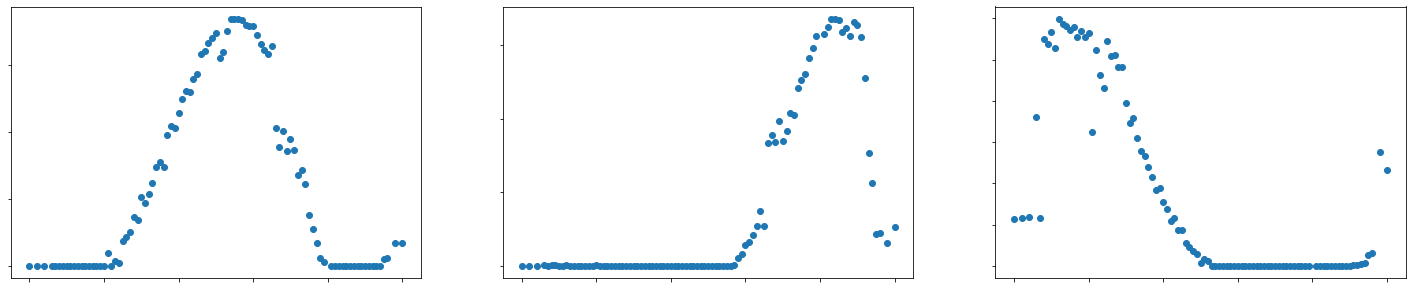

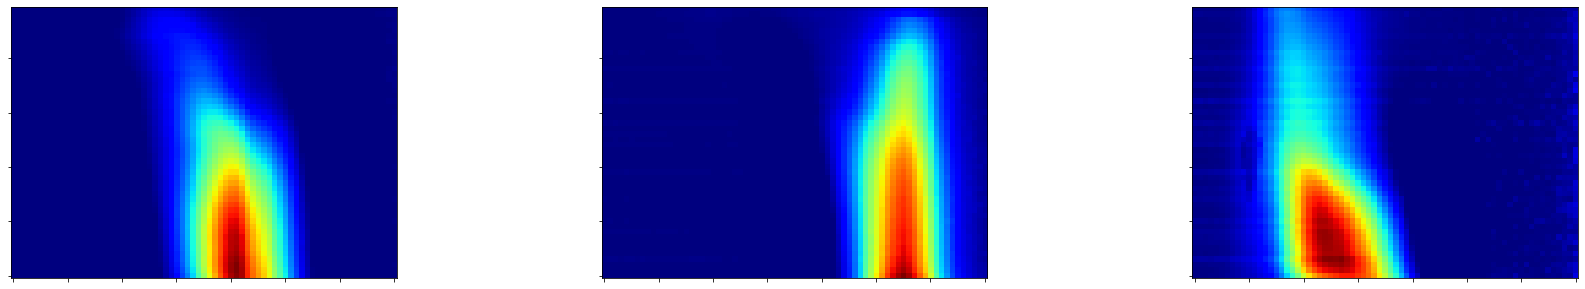

In [9]:
#@title NMF for Entire Dataset

number_of_components =  3#@param {type:"integer"}

#Normalization 
scaler = MinMaxScaler()
luminescence_vec_norm = scaler.fit_transform(luminescence_vec)

model = decomposition.NMF(n_components=number_of_components)

luminescence_vec_t  = model.fit_transform(luminescence_vec_norm[:,2:])

components = model.components_

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"
params = {'mathtext.default': 'regular' }

#Plotting of Loading Maps
figure, ax = plt.subplots(nrows = 1, ncols = number_of_components, figsize = (25,5))
for i in range(number_of_components):

  ax[i].scatter(composition.iloc[0]*2,components[i])
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].set_yticklabels([])
  ax[i].set_xticklabels([])  

fig,ax = plt.subplots(nrows = 1, ncols = number_of_components, figsize = (30,5))
for i in range(number_of_components):
  ax[i].imshow(luminescence_vec_t[:,i].reshape([len(luminescence_time), len(luminescence_wavelength)]), cmap = 'jet')
  #ax[i].set_aspect(0.5)
  ax[i].invert_yaxis()
  ax[i].set_xticks(np.arange(0,len(luminescence_wavelength),10))
  ax[i].set_xticklabels(luminescence_wavelength[0::10])
  ax[i].set_yticks(np.arange(0,len(luminescence_time),10))
  ax[i].set_yticklabels(luminescence_time[0::10])
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].set_yticklabels([])
  ax[i].set_xticklabels([])